In [1]:
import sys
import os
sys.path.append(os.getcwd()+"/../..")
from src import paths

import pandas as pd

from datasets import Dataset

In [ ]:
# Read the test rids
test_rids = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/test_rids.txt"), header=None).values.flatten()

In [ ]:
# Kisim diagnoses
kisim_diagnoses = pd.read_csv(os.path.join(paths.DATA_PATH_SEANTIS, "kisim_diagnoses.csv")).rename(columns={"diagnosis_label": "text"})

# Some text will be doubled in dataset as doctors just append, and there is now way to know from this data what text belongs to what.
# LastUpdateDateTime is shared with first part of diagnosis id and then the second part is the indicator of the individual texts so 4085680|1 for example

def filter_duplicate_entries(df:pd.DataFrame) -> pd.DataFrame:
    """
    As text is sometimes just appended to a report, we need to find reports that start the same way and only keep the most recent/longest one.
    Per default, this function considers the first 100 characters of the text as criteria for filtering.

    Args:
        df (pd.DataFra me): The dataframe to filter. Must contain a column "text", "research_id" and "LastUpdateDateTime"

    Returns:
        pd.DataFrame: The filtered dataframe
    """

    # Sort by LastUpdateDateTime
    df = df.sort_values("LastUpdateDateTime", ascending=False)

    # Group by research_id and text_start
    text_start = df["text"].apply(lambda x: x[:100] if len(x) > 100 else x)
    grouped = df.groupby(["research_id", text_start]).head(1)

    return grouped

def preprocess_text(text):
    """
    Preprocesses the text by removing empty lines and adding 'INDENT' to lines starting with '-', '·', '··', and removing '·'

    Args:
        text (str): The text to preprocess

    Returns:
        str: The preprocessed text
    """

    text = text.split("\n")

    # Remove empty strings and whitespace-only strings
    try:
        lines = [str(item) for item in text if not (not item or item.isspace())]

    except:
        print(text)
    
    # Add 'INDENT' to lines starting with '-', '·', '··', and remove '·'
    lines = ['INDENT ' + item.replace('·', '') if item.startswith(('-', '·', '··')) else item for item in lines]

    return "\n".join(lines)

def preprocess_df(df:pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the dataframe by removing nan values and filtering duplicate entries.

    Args:
        df (pd.DataFrame): The dataframe to preprocess

    Returns:
        pd.DataFrame: The preprocessed dataframe
    """

    # Number of nan values in text
    print(f"Number of nan values in text: {df['text'].isna().sum()}")
    df.dropna(subset=["text"], inplace=True)

    df = filter_duplicate_entries(df)

    df["text"] = df["text"].apply(preprocess_text)

    return df

kisim_diagnoses = preprocess_df(kisim_diagnoses)

Number of nan values in text: 2


In [ ]:
# Remove test entries
from src.utils import load_ms_data

test_data = load_ms_data("all")["test"]
kisim_diagnoses = kisim_diagnoses[~kisim_diagnoses["text"].isin(test_data["text"])]

In [ ]:
# Reports kisim diagnoses also contains more texts
kisim_reports_diagnoses = pd.read_csv(os.path.join(paths.DATA_PATH_RSD, "reports_kisim_diagnoses.csv")).rename(columns={"diagnosis_label": "text"})
kisim_reports_diagnoses = preprocess_df(kisim_reports_diagnoses)

Number of nan values in text: 14


In [ ]:
# Combine the two datasets
df_all = pd.concat([kisim_diagnoses, kisim_reports_diagnoses], axis=0)

# Drop double diagnoses ids
df_all.drop_duplicates(subset="diagnosis_id", inplace=True)

# Save the combined dataset
os.makedirs(paths.DATA_PATH_PREPROCESSED/"text-finetune", exist_ok=True)
df_all.to_csv(os.path.join(paths.DATA_PATH_PREPROCESSED, "text-finetune/kisim_diagnoses_combined.csv"), index=False)

# Huggingface
df = Dataset.from_dict({"text": df_all["text"]})
df.save_to_disk(os.path.join(paths.DATA_PATH_PREPROCESSED, "text-finetune/kisim_diagnoses"))

Saving the dataset (0/1 shards):   0%|          | 0/41409 [00:00<?, ? examples/s]

In [ ]:
# Number of tokens
df = Dataset.load_from_disk(os.path.join(paths.DATA_PATH_PREPROCESSED, "text-finetune/kisim_diagnoses"))

# tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/"Llama2-MedTuned-13b")

def tokenize(example):
    example = tokenizer(example["text"], 
                        add_special_tokens=False)
    return example
    

df_tokenized = df.map(tokenize)

Map:   0%|          | 0/41409 [00:00<?, ? examples/s]

In [ ]:
# Number of tokens
num_tokens = [len(input) for input in df_tokenized["input_ids"]]
print("Number of training tokens: ", sum(num_tokens))
print("Number of reports: ", len(df))

Number of training tokens:  4870424
Number of reports:  41409


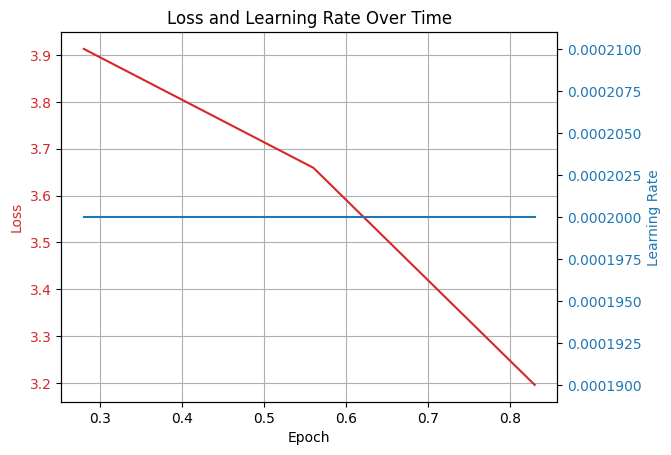

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_and_lr(data):
    epochs = [entry['epoch'] for entry in data]
    loss_values = [entry['loss'] for entry in data]
    lr_values = [entry['learning_rate'] for entry in data]

    # Create subplots
    fig, ax1 = plt.subplots()

    # Plot loss on primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss_values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create secondary y-axis for learning rate
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Learning Rate', color=color)
    ax2.plot(epochs, lr_values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add grid
    ax1.grid(True)

    # Title and display
    plt.title('Loss and Learning Rate Over Time')
    plt.show()

# plot_loss_and_lr(trainer.state.log_history[:-1])

In [ ]:
from src.utils import load_line_label_data
# Comparison medication kisim reports
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 20)
line_labels = pd.DataFrame(load_line_label_data()["train"])
line_labels[line_labels["class_agg"] == "medms"]["text"].iloc[10]
# It seems that in reports they don't have dosis and when, but more like start date and what medication
line_labels[line_labels["class_agg"] == "medo_unk_do_so"]["text"]

In [ ]:
# Medications
kisim_medications = pd.read_csv(os.path.join(paths.DATA_PATH_SEANTIS, "kisim_medication.csv"))
kisim_medications_text = kisim_medications["medication_name"]
print(kisim_medications_text.iloc[0])

In [ ]:
# medications.csv not really helpful as of now
medications = pd.read_csv(os.path.join(paths.DATA_PATH_SEANTIS, "medications.csv"))
medications.head()

In [ ]:

# I will adapt the code from original project, that also produced preprocessed data for previous tasks.
# Then c

def _get_diag_lines(diag):
    
    '''
    get list of text lines for a kisim_diagnoses.csv 'diag_label' entry
    
    input:
    - diag: str with text from one 'diag_label' entry
    
    ouptut:
    - diag_lines: list of text lines
    
    '''
    
    diag_lines = diag.splitlines()
    diag_lines = [item for item in diag_lines if not (not item or item.isspace())]
    diag_lines = ['INDENT ' + item.replace('·', '') if item.startswith(('-', '·', '··')) else item for item in diag_lines]
    
    return diag_lines


def extract_longest_diag_per_rid(df, var_date, var_diag):
    '''
    function to extract longest lines of all diagnosis texts for each research id
    
    input:
    - df: dataframe containing all information
    - var_date: column name of date column
    - var_diag: column name of diagnosis text column
    
    ouptut:
    - dict_diags: dictionary of diagnosis text (key: research id-diag_index-date, value: list of text lines)   
    '''
    
    dict_diags = dict()
    list_vars = [var_date, var_diag]

    for rid in df['research_id'].unique():

        list_lines = list()
        date = ''
        _df = df[df['research_id'] == rid].sort_values([var_date])[list_vars]

        for diag_index, row in _df.iterrows():

            diag = row[var_diag]

            if isinstance(diag, str):
                
                diag_lines = _get_diag_lines(diag)
                
                if len(diag_lines) >= len(list_lines):
                    
                    list_lines = diag_lines[:]
                    date = str(row[var_date])[:11]
                    
        key = '_'.join((rid, str(diag_index), date))
                
        dict_diags[key] = list_lines

    return dict_diags